In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"
df = pd.read_csv(IN_PATH, sep="\t")

<ipython-input-3-c2e4cd69b53a>:2: DtypeWarning: Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(IN_PATH, sep="\t")


In [4]:
df["date"] = pd.to_datetime(df["date"])
df = df.dropna(subset=["date"])

keep only data that overlaps with the local data we have (in time series) 

In [5]:
articlesReported = df[["source", "key"]].groupby("source").agg(len).rename(columns={"key":"articlesReported"})
df = pd.merge(df, articlesReported, on="source", how="left")

In [6]:
firstLocDate = min(df.loc[df["national"] == False, "date"])
clusteredDates = df[["clustNum", "date"]].groupby(by="clustNum").agg(list).reset_index()
clusteredDates["minDate"] = clusteredDates["date"].apply(lambda x: max(x))

#we can only keep clusters whose first article occured after the 
#first day of local coverage in our data, 4/1
keepClusts = clusteredDates.loc[clusteredDates["minDate"] >= firstLocDate, "clustNum"]

df = df[df["clustNum"].isin(keepClusts)]
len(df)

1178397

In [7]:
clustDf = df[["clustNum", "source", "key", "title", "date", "state", "national", "median_hh_inc", "rural_pct", "total_population", "articlesReported"]].groupby("clustNum").agg(list)

clustDf["clustSize"] = clustDf["key"].apply(len)

clustDf = clustDf[clustDf["clustSize"] < 3000]


clustDf["duration"] = ((clustDf["date"].apply(max) - clustDf["date"].apply(min)) / np.timedelta64(1, "D")) + 1

def firstDayPercent(inList): 
    dayOne = min(inList)
    return np.mean([day == dayOne for day in inList if day])

clustDf["dayOnePercent"] = clustDf["date"].apply(firstDayPercent)

## Most clusters are shortish

Text(0.5, 0, 'Cluster Duration')

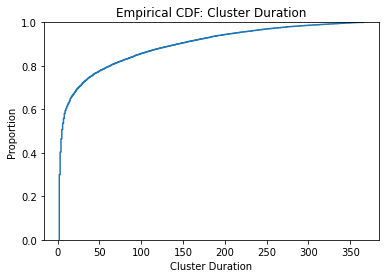

In [8]:
over1 = clustDf[(clustDf["duration"] >= 2)]
sns.ecdfplot(x="duration", data=over1)
plt.title("Empirical CDF: Cluster Duration")
plt.xlabel("Cluster Duration")

In [9]:
for currCutoff in [1, 10, 20, 30, 50]: 
    print(currCutoff)
    print(len(over1[over1["duration"] <= currCutoff]) / len(over1))

1
0.0
10
0.6049576708833941
20
0.6773717988329699
30
0.7230378093026951
50
0.7774962702707474


In [10]:
timeFiltered = clustDf[(clustDf["duration"] >= 2) & (clustDf["duration"] <= 90)]
print(len(timeFiltered))
print(len(timeFiltered) / len(clustDf))

#all clusts under 30 - clusts under 30, geq 2
print(84.65 - 46.16138)

95465
0.5248069047030043
38.488620000000004


# apply outlet num cutoff

In [14]:
timeFiltered["outletCount"] = timeFiltered["source"].apply(lambda x: len(set(x)))

<ipython-input-14-fd570a4932fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeFiltered["outletCount"] = timeFiltered["source"].apply(lambda x: len(set(x)))


proportion of stories kept after all three cutoffs 

In [13]:
timeFiltered["natPercent"] = timeFiltered["national"].apply(np.mean)

<ipython-input-13-bdda5d55347f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeFiltered["natPercent"] = timeFiltered["national"].apply(np.mean)


In [15]:
def getStoryDay(inList): 
    dayOne = min(inList)
    return [((date - dayOne) / np.timedelta64(1, "D")) for date in inList]

timeFiltered["storyDay"] = timeFiltered["date"].apply(getStoryDay)

<ipython-input-15-f7207d80f4bc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeFiltered["storyDay"] = timeFiltered["date"].apply(getStoryDay)


In [16]:
timeFiltered["uniqueDays"] = timeFiltered["date"].apply(lambda x: len(set(x)))

<ipython-input-16-0ecdf79b730c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeFiltered["uniqueDays"] = timeFiltered["date"].apply(lambda x: len(set(x)))


In [19]:
def getArticleIndex(inRow): 
    days = sorted(list(set(inRow["date"])))
    indexList = []
    
    #for each date, get which day of coverage it was in terms 
    #of articles published before it 
    for date in inRow["date"]: 
        indexList.append(days.index(date) / (inRow["uniqueDays"] -1))
    return indexList

timeFiltered["storyPropCount"] = timeFiltered.apply(getArticleIndex, axis=1)

<ipython-input-19-b58f0b0261ca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeFiltered["storyPropCount"] = timeFiltered.apply(getArticleIndex, axis=1)


In [38]:
from collections import Counter
def getPeakPercent(storyDays): 
    peakDay, peakCount = Counter(storyDays).most_common()[0]
    
    #example: if a story has days 0-4, then day 1 would be 1 / 4 == .25. 
    #this way, day 0 is always zero and day 1 is always one 
    #noting that this is in terms of days between first and last article, not days that we have coverage 
    peakPercent = peakDay / max(storyDays)
    return (peakDay, peakCount, peakPercent)
    
timeFiltered[["peakDay", "peakCount", "peakPercent"]] = list(timeFiltered["storyDay"].apply(getPeakPercent))

<ipython-input-38-5529dbf902a0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeFiltered[["peakDay", "peakCount", "peakPercent"]] = list(timeFiltered["storyDay"].apply(getPeakPercent))
<ipython-input-38-5529dbf902a0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeFiltered[["peakDay", "peakCount", "peakPercent"]] = list(timeFiltered["storyDay"].apply(getPeakPercent))
<ipython-input-38-5529dbf902a0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [49]:
#first cutoff should just be only looking at stories where the peak occurs after day 0 
peakFiltered = timeFiltered[timeFiltered["peakDay"] > 0]
print(f"dimension of delayed peak df {peakFiltered.shape}") 
print(f"dimension of df with all stories {timeFiltered.shape}") 

print(f"proportion of stories with peak after day 0 {(1 - (len(timeFiltered) - len(peakFiltered)) / len(timeFiltered))}")

dimension of delayed peak df (31794, 21)
dimension of df with all stories (95465, 21)
proportion of stories with peak after day 0 0.3330435238045357


In [88]:
filtLong = timeFiltered.explode(["source", "key", "title", "date", "storyDay", "state", "storyPropCount", "national", "median_hh_inc", "rural_pct", "total_population", "articlesReported"]).reset_index()

In [89]:
filtLong["storyPropDays"] = (filtLong["storyDay"]) / (filtLong["duration"] - 1) 

In [90]:
latePeakers = filtLong[filtLong["peakDay"] > 0]
earlyPeakers = filtLong[filtLong["peakDay"] == 0]

In [91]:
#now get the outlet level mean of stories in terms of when their stories appear in coverage 
outletClustsEarly = earlyPeakers[["source", "storyPropDays", "national", "articlesReported"]].groupby("source")\
.agg({"national":list, "articlesReported":list, "storyPropDays":[np.mean, len]}).droplevel([0], axis=1) #.sort_values(["mean", "len"], ascending=False)
outletClustsEarly.columns = ["national", "articlesReported", "storyPropDaysMean", "numStories"]
outletClustsEarly["national"] = outletClustsEarly["national"].apply(lambda x: x[0])
outletClustsEarly["articlesReported"] = outletClustsEarly["articlesReported"].apply(lambda x: x[0])

outletClustsLate = latePeakers[["source", "storyPropDays", "national", "articlesReported"]].groupby("source")\
.agg({"national":list, "articlesReported":list, "storyPropDays":[np.mean, len]}).droplevel([0], axis=1) #.sort_values(["mean", "len"], ascending=False)
outletClustsLate.columns = ["national", "articlesReported", "storyPropDaysMean", "numStories"]
outletClustsLate["national"] = outletClustsLate["national"].apply(lambda x: x[0])
outletClustsLate["articlesReported"] = outletClustsLate["articlesReported"].apply(lambda x: x[0])


# is scooped coverage more national or local? 

If we look at coverage for scooped (late peak) stories, we see that these are more likely to be national

In [92]:
print(f'proportion of national in all coverage: {np.mean(earlyPeakers["national"] == True)}')
print(f'proportion of national in scooped coverage: {np.mean(latePeakers["national"] == True)}')

proportion of national in all coverage: 0.659448198048126
proportion of national in scooped coverage: 0.7762578730383652


In [96]:
#look at distribution? 
earlyNatPercent = earlyPeakers[["clustNum", "natPercent"]].groupby(by="clustNum").agg(lambda x: list(x)[0])
lateNatPercent = latePeakers[["clustNum", "natPercent"]].groupby(by="clustNum").agg(lambda x: list(x)[0])

In [ ]:
#finding: national 

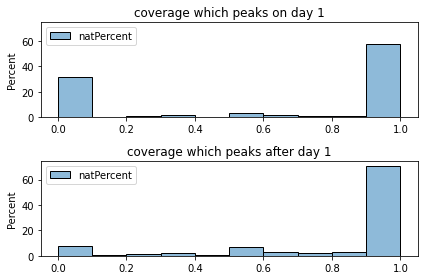

In [110]:
fig, axs = plt.subplots(2, sharey=True)
sns.histplot(earlyNatPercent, stat="percent", bins=np.arange(0, 1.1, .1), ax=axs[0])
axs[0].set_title("coverage which peaks on day 1")

sns.histplot(lateNatPercent, stat="percent", bins=np.arange(0, 1.1, .1), ax=axs[1])
axs[1].set_title("coverage which peaks after day 1")
plt.tight_layout()

In [86]:
#is scooped coverage more national or local? 

## do national or local outlets tend to be the first to report scoops? 

we will also want just the first story in story clusters from each outlet (below)

In [75]:
#get the first day of coverage 
filtNoDups = filtLong.reset_index().sort_values(["clustNum", "date"]).drop_duplicates(subset=["clustNum", "source"])

firstCoverageClusters = filtNoDups[["source", "storyPropDays", "national"]].groupby("source")\
.agg({"national":list, "storyPropDays":[np.mean, len]}).droplevel([0], axis=1) #.sort_values(["mean", "len"], ascending=False)
firstCoverageClusters.columns = ["national", "storyPropDaysMean", "numStories"]
firstCoverageClusters["national"] = firstCoverageClusters["national"].apply(lambda x: x[0])

#now get the outlet level mean of stories 
#firstCoverageClusters = fourtyNoDups[["source", "storyProportion"]].groupby("source").agg([np.mean, len]).droplevel([0], axis=1).sort_values(["mean", "len"], ascending=False)

In [77]:
coverageClusters

,national,articlesReported,storyPropDaysMean,numStories
source,,,,
21stcenturywire,True,853,0.369399,154
911truthorg,True,11,0.555556,2
abcnews,True,8884,0.274617,2231
acnlatitudes,True,25,0.610169,8
activistpost,True,3020,0.316794,982
...,...,...,...,...
x22report,True,253,0.013275,45
yahoonews,True,4720,0.4203,631
yellowspringsnews,False,444,0.491732,61


Text(0.5, 0.98, 'Distribution of When Outlets Report During the Life of a Story [0,1]')

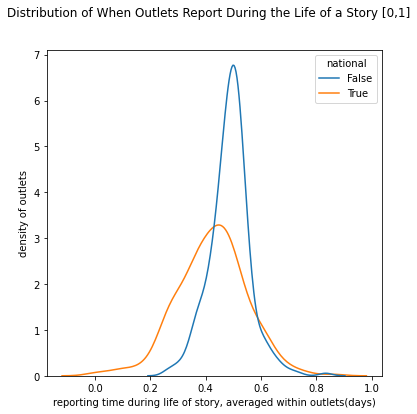

In [111]:

fig, ax = plt.subplots(1, figsize=(6, 6))
sns.kdeplot(x="storyPropDaysMean", hue="national", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 10], ax=ax)
ax.set_xlabel("reporting time during life of story, averaged within outlets(days)")
ax.set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

In [ ]:

fig, ax = plt.subplots(1, figsize=(6, 6))
sns.kdeplot(x="storyPropDaysMean", hue="national", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 100], ax=ax)
ax.set_xlabel("reporting time during life of story, averaged within outlets(days)")
ax.set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

Text(0.5, 0.98, 'Distribution of When Stories are Reported [0,1]')

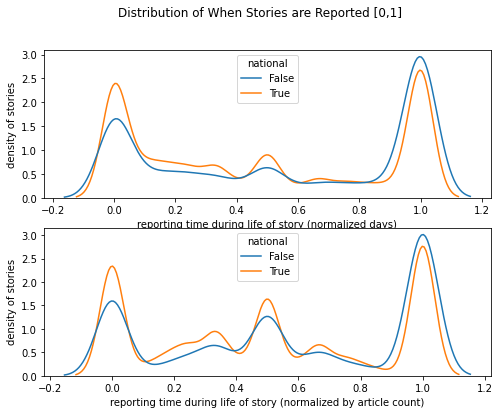

In [1315]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDays", hue="national", common_norm=False, data=fourtyLong, ax=axs[0])
axs[0].set_xlabel("reporting time during life of story (normalized days)")
axs[0].set_ylabel("density of stories")

sns.kdeplot(x="storyPropCount", hue="national", common_norm=False, data=fourtyLong, ax=axs[1])
axs[1].set_xlabel("reporting time during life of story (normalized by article count)")
axs[1].set_ylabel("density of stories")

fig.suptitle("Distribution of When Stories are Reported [0,1]")

## Same plots, but only consider first reporting

Text(0.5, 0.98, 'Distribution of When Outlets Report During the Life of a Story [0,1]')

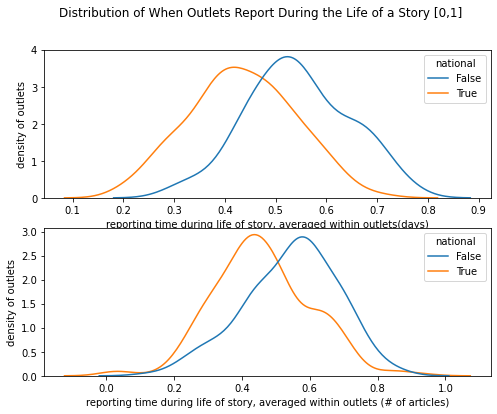

In [1316]:

fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDaysMean", hue="national", common_norm=False, data=firstCoverageClusters[firstCoverageClusters["numStories"] > 100], ax=axs[0])
axs[0].set_xlabel("reporting time during life of story, averaged within outlets(days)")
axs[0].set_ylabel("density of outlets")

sns.kdeplot(x="storyPropCountMean", hue="national", common_norm=False, data=firstCoverageClusters[firstCoverageClusters["numStories"] > 10], ax=axs[1])
axs[1].set_xlabel("reporting time during life of story, averaged within outlets (# of articles)")
axs[1].set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

Text(0.5, 0.98, 'Distribution of When Stories are Reported [0,1]')

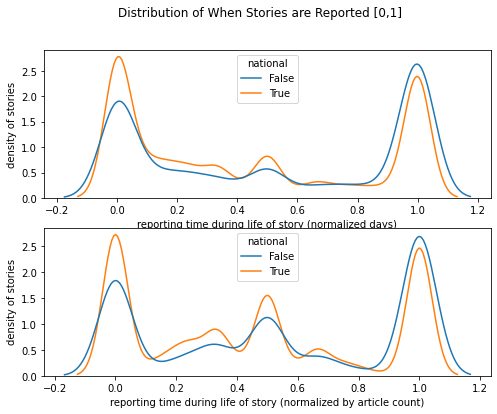

In [1317]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDays", hue="national", common_norm=False, data=fourtyNoDups, ax=axs[0])
axs[0].set_xlabel("reporting time during life of story (normalized days)")
axs[0].set_ylabel("density of stories")

sns.kdeplot(x="storyPropCount", hue="national", common_norm=False, data=fourtyNoDups, ax=axs[1])
axs[1].set_xlabel("reporting time during life of story (normalized by article count)")
axs[1].set_ylabel("density of stories")

fig.suptitle("Distribution of When Stories are Reported [0,1]")

let's get some examples of local and national early and late outlets 

In [1318]:
lenSorted = coverageClusters[coverageClusters["numStories"] > 100].sort_values(["storyPropCountMean", "storyPropDaysMean"])
lenSorted[lenSorted["national"] == False].head(5)

,national,articlesReported,storyPropDaysMean,storyPropCountMean,numStories
source,,,,,
theseattletimes,False,22736,0.373038,0.35229,1836
deseretnews,False,5011,0.442337,0.436611,169
therepublic,False,5053,0.46446,0.451335,384
theheraldnet,False,3954,0.461885,0.459505,146
startribune,False,4030,0.458385,0.47578,296


In [1319]:
lenSorted[lenSorted["national"] == False].tail(5)

,national,articlesReported,storyPropDaysMean,storyPropCountMean,numStories
source,,,,,
thebrainerddailydispatch,False,4666,0.719611,0.71637,282
theirontontribune,False,2353,0.686962,0.720999,133
thejamestownsun,False,3969,0.721366,0.73266,240
grandforksherald,False,4145,0.744008,0.748389,321
themitchelldailyrepublic,False,3900,0.75318,0.75299,208


In [1320]:
#let's get some stories from the mitchell daily republic

In [1321]:
fourtyLong = fourtyLong.reset_index()

In [1322]:
#mitchellClusts = list(set(fourtyLong.reset_index().loc[fourtyLong["source"] == "themitchelldailyrepublic", "clustNum"]))

In [1323]:
mitchellRows = fourtyLong[fourtyLong["clustNum"].isin(mitchellClusts)]
mitchellClusts[:5]

[520.0, 20488.0, 78344.0, 13835.0, 159754.0]

In [1324]:
fourtyNoDups.loc[fourtyLong["source"] == "themitchelldailyrepublic", ["clustNum", "source", "date", "title", "clustSize", "duration", "dayOnePercent", "duration", "uniqueDays", "storyPropDays"]].sort_values("uniqueDays", ascending=False)

,clustNum,source,date,title,clustSize,duration,dayOnePercent,duration,uniqueDays,storyPropDays
24038,22282.0,themitchelldailyrepublic,2020-07-15,High-profile Twitter accounts swept up in wave...,245,24.0,0.102041,24.0,19,0.0
22979,21620.0,themitchelldailyrepublic,2020-12-13,"Sources say, suspected Russian hackers spied o...",529,22.0,0.011342,22.0,17,0.238095
21891,20488.0,themitchelldailyrepublic,2020-08-02,Wild's Dumba kneels during anthem,36,30.0,0.027778,30.0,10,0.103448
54976,59730.0,themitchelldailyrepublic,2020-12-23,Second Black man shot dead by police in Ohio c...,112,10.0,0.008929,10.0,9,0.111111
20830,19080.0,themitchelldailyrepublic,2020-10-07,Women creators of genetic 'scissors' win Nobel...,59,26.0,0.016949,26.0,8,0.2
...,...,...,...,...,...,...,...,...,...,...
52464,56534.0,themitchelldailyrepublic,2020-11-29,High school sailing team navigates uncertain w...,16,8.0,0.125000,8.0,2,1.0
52446,56530.0,themitchelldailyrepublic,2020-08-29,Four young entrepreneurs Kickstart their 'dogh...,7,8.0,0.142857,8.0,2,1.0
50677,53530.0,themitchelldailyrepublic,2020-07-27,Rising pregnancy complications coincide with r...,7,2.0,0.142857,2.0,2,1.0
50205,52755.0,themitchelldailyrepublic,2020-08-21,A little fishing tackle goes a long way after ...,7,8.0,0.142857,8.0,2,1.0


In [1325]:


lenSorted[lenSorted["national"] == True].head(5)

lenSorted[lenSorted["national"] == True].tail(5)

,national,articlesReported,storyPropDaysMean,storyPropCountMean,numStories
source,,,,,
needtoknow,True,874,0.633118,0.686932,133
sgtreport,True,5129,0.639538,0.698879,529
stillnessinthestorm,True,3832,0.694819,0.723604,448
principiascientificinternational,True,1098,0.671632,0.723981,134
prepareforchange,True,1532,0.784196,0.819845,103


In [1326]:
veracityDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/raw/NELA-gt-2020/labels.csv")
veracityDf["label"] = 2 - veracityDf["label"]
veracityDf.columns = ["source", "veracityScore"]


In [1327]:
coverageClusters = pd.merge(coverageClusters.reset_index(), veracityDf, on="source", how="left")

In [1331]:
fourtyLong = pd.merge(fourtyLong.reset_index(), veracityDf, on="source", how="left")

In [1332]:
#and remake the firstCoverageClusters dataframe to include the veracity labels 
fourtyNoDups = fourtyLong.sort_values(["clustNum", "date"]).drop_duplicates(subset=["clustNum", "source"])

firstCoverageClusters = fourtyNoDups[["source", "storyPropDays","storyPropCount", "national", "veracityScore"]].groupby("source")\
.agg({"national":list, "veracityScore":list, "storyPropDays":[np.mean], "storyPropCount":[np.mean, len]}).droplevel([0], axis=1) #.sort_values(["mean", "len"], ascending=False)
firstCoverageClusters.columns = ["national", "veracityScore", "storyPropDaysMean", "storyPropCountMean", "numStories"]
firstCoverageClusters["national"] = firstCoverageClusters["national"].apply(lambda x: x[0])
firstCoverageClusters["veracityScore"] = firstCoverageClusters["veracityScore"].apply(lambda x: x[0])

KeyError: "['veracityScore'] not in index"

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDaysMean", hue="veracityScore", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 100], ax=axs[0])
axs[0].set_xlabel("reporting time during life of story, averaged within outlets(days)")
axs[0].set_ylabel("density of outlets")

sns.kdeplot(x="storyPropCountMean", hue="veracityScore", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 10], ax=axs[1])
axs[1].set_xlabel("reporting time during life of story, averaged within outlets (# of articles)")
axs[1].set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDays", hue="veracityScore", common_norm=False, data=fourtyLong, ax=axs[0])
axs[0].set_xlabel("reporting time during life of story (normalized days)")
axs[0].set_ylabel("density of stories")

sns.kdeplot(x="storyPropCount", hue="veracityScore", common_norm=False, data=fourtyLong, ax=axs[1])
axs[1].set_xlabel("reporting time during life of story (normalized by article count)")
axs[1].set_ylabel("density of stories")

fig.suptitle("Distribution of When Stories are Reported [0,1]")

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDaysMean", hue="veracityScore", common_norm=False, data=firstCoverageClusters[firstCoverageClusters["numStories"] > 100], ax=axs[0])
axs[0].set_xlabel("reporting time during life of story, averaged within outlets(days)")
axs[0].set_ylabel("density of outlets")

sns.kdeplot(x="storyPropCountMean", hue="veracityScore", common_norm=False, data=firstCoverageClusters[firstCoverageClusters["numStories"] > 10], ax=axs[1])
axs[1].set_xlabel("reporting time during life of story, averaged within outlets (# of articles)")
axs[1].set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDays", hue="veracityScore", common_norm=False, data=fourtyNoDups, ax=axs[0])
axs[0].set_xlabel("reporting time during life of story (normalized days)")
axs[0].set_ylabel("density of stories")

sns.kdeplot(x="storyPropCount", hue="veracityScore", common_norm=False, data=fourtyNoDups, ax=axs[1])
axs[1].set_xlabel("reporting time during life of story (normalized by article count)")
axs[1].set_ylabel("density of stories")

fig.suptitle("Distribution of When Stories are Reported [0,1]")

array([[ 1.        , -0.13540109],
       [-0.13540109,  1.        ]])

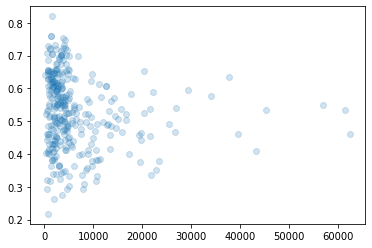

In [1362]:
test = coverageClusters[coverageClusters["numStories"] > 50]
plt.scatter(test["articlesReported"], test["storyPropCountMean"], alpha=.2)
np.corrcoef(list(test["articlesReported"]), list(test["storyPropCountMean"]))

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDaysMean", hue="veracityScore", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 100], ax=axs[0])
axs[0].set_xlabel("reporting time during life of story, averaged within outlets(days)")
axs[0].set_ylabel("density of outlets")

sns.kdeplot(x="storyPropCountMean", hue="veracityScore", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 10], ax=axs[1])
axs[1].set_xlabel("reporting time during life of story, averaged within outlets (# of articles)")
axs[1].set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

do certain states report first? 

In [1177]:
#get only the local articles 
stateReportTimes = fourtyLong.loc[fourtyLong["national"] == False, ["state", "storyPropCount", "storyPropDays"]].groupby("state").agg([np.mean, len]).droplevel([0], axis=1)
stateReportTimes.columns = ["storyPropCountMean", "len", "storyPropDaysMean", "lenDup"]
stateReportTimes[stateReportTimes["len"] > 40].sort_values("storyPropDaysMean", ascending=False).drop(columns=["len"])
#.sort_values("storyPropCount")

,storyPropCountMean,storyPropDaysMean,lenDup
state,,,
Tennessee,0.692143,0.715493,50
North Dakota,0.714584,0.705799,865
Hawaii,0.699961,0.677786,446
South Dakota,0.662202,0.659862,348
Wisconsin,0.672135,0.6584,161
Minnesota,0.632692,0.62743,2826
Alabama,0.632806,0.623684,161
Missouri,0.63503,0.614781,1300
Pennsylvania,0.611398,0.605764,1700


In [1171]:
fourtyLong[fourtyLong["state"] == "North Dakota"]

,index,clustNum,source,key,title,date,state,national,median_hh_inc,rural_pct,...,clustSize,duration,dayOnePercent,outletCount,natPercent,storyDay,uniqueDays,storyPropCount,storyPropDays,veracityScore
201,201,154.0,theforum,100847,"Minnesota National Guard, Air Force plan secon...",2020-05-11,North Dakota,False,54926.0,10.434777,...,14,9.0,0.071429,10,0.000000,7.0,4,0.666667,0.875,NaN
202,202,154.0,grandforksherald,100852,"Minnesota National Guard, Air Force plan secon...",2020-05-11,North Dakota,False,50652.0,16.769118,...,14,9.0,0.071429,10,0.000000,7.0,4,0.666667,0.875,NaN
403,403,416.0,theforum,323865,Koepka makes solid start in bid for PGA Champi...,2020-08-07,North Dakota,False,54926.0,10.434777,...,18,7.0,0.333333,13,0.277778,4.0,4,0.666667,0.666667,NaN
404,404,416.0,grandforksherald,323873,Koepka makes solid start in bid for PGA Champi...,2020-08-07,North Dakota,False,50652.0,16.769118,...,18,7.0,0.333333,13,0.277778,4.0,4,0.666667,0.666667,NaN
449,449,520.0,theforum,285628,Vikings finalizing multi-year contract extensi...,2020-07-22,North Dakota,False,54926.0,10.434777,...,21,5.0,0.380952,13,0.095238,0.0,5,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114410,114260,194951.0,grandforksherald,24256,Hauser: Is your soul weary?,2020-04-13,North Dakota,False,50652.0,16.769118,...,4,2.0,0.250000,4,0.000000,1.0,2,1.0,1.0,NaN
115659,115509,202643.0,devilslakedailyjournal,65723,White House unveils blueprint to expand state ...,2020-04-28,North Dakota,False,50776.0,34.992577,...,24,2.0,0.041667,23,0.083333,1.0,2,1.0,1.0,NaN
116310,116159,207408.0,theforum,549399,Morken: Patience pays off while bow hunting deer,2020-11-10,North Dakota,False,54926.0,10.434777,...,16,5.0,0.062500,15,0.000000,4.0,2,1.0,1.0,NaN
116311,116160,207408.0,grandforksherald,549405,Morken: Patience pays off while bow hunting deer,2020-11-10,North Dakota,False,50652.0,16.769118,...,16,5.0,0.062500,15,0.000000,4.0,2,1.0,1.0,NaN


In [538]:
myList = ["a, b, c"]
indList = [0]
myList

AttributeError: 'list' object has no attribute 'values'

In [539]:
def getMeanCoverage(inSer): 
    storyProps = inSer["storyProportion"]
    rel = [storyProps[i] for i in range(0, len(inSer["label"])) if inSer["label"][i] == 0] 
    mixed = [storyProps[i] for i in range(0, len(inSer["label"])) if inSer["label"][i] == 1]
    unrel = [storyProps[i] for i in range(0, len(inSer["label"])) if inSer["label"][i] == 2]
    """
    relMean = np.nan
    if len(relInds) > 0: 
        relMean = np.mean(inSer["storyProportion"][relInds])
        
    mixedMean = np.nan
    if len(mixedInds) > 0: 
        print(mixedInds)
        print(inSer["storyProportion"])
        mixedMean = np.mean(inSer["storyProportion"][mixedInds])
    
    unrelMean = np.nan
    if len(unrelInds) > 0: 
        unrelMean = np.mean(inSer["storyProportion"][unrelInds])
    """
    
    return (np.mean(rel), np.mean(mixed), np.mean(unrel)) 

veracityDiff[["relMean", "mixedMean", "unrelMean"]] = list(veracityDiff.apply(getMeanCoverage, axis=1))

/opt/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [541]:
#now get diffs for for rel and unrel 
relUnrel = veracityDiff.dropna(subset=["relMean", "unrelMean"])
relUnrel["relUnrelDiff"] = relUnrel["relMean"] - relUnrel["unrelMean"]

<ipython-input-541-cec816e33f90>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relUnrel["relUnrelDiff"] = relUnrel["relMean"] - relUnrel["unrelMean"]


In [557]:
relUnrel["clustSize"]

clustNum
8.0         10
24.0         7
79.0        28
95.0        14
110.0       31
            ..
208587.0     4
208813.0    12
208819.0     4
209116.0     3
209248.0     5
Name: clustSize, Length: 6488, dtype: int64